In [4]:
import os
import pandas as pd
import numpy as np

In [5]:
path = "UTKFace/"
files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 23708
100_0_0_20170112213500903.jpg.chip.jpg


In [6]:
import cv2
images = []
ages = []
genders = []
for file in files:
    image = cv2.imread(path+file,0)#load in grayscale mode
    image = cv2.resize(image,dsize=(64,64))
    image = image.reshape((image.shape[0],image.shape[1],1))
    images.append(image)
    split_var = file.split('_')
    ages.append(split_var[0])
    genders.append(int(split_var[1]) )

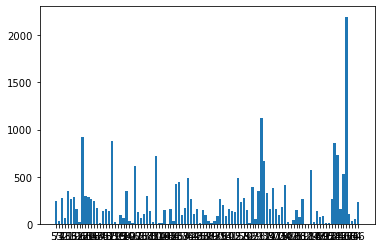

Max value: 99


In [7]:
import matplotlib.pyplot as plt
x_ages = list(set(ages))
y_ages = [ages.count(i) for i in x_ages]
plt.bar(x_ages,y_ages)
plt.show()
print("Max value:",max(ages))

Gender: 0 Age: 14


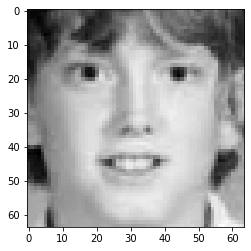

In [8]:
def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()
idx = 500
sample = images[idx]
print("Gender:",genders[idx],"Age:",ages[idx])
display(sample)

In [9]:
def age_group(age):
    if age >=0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4

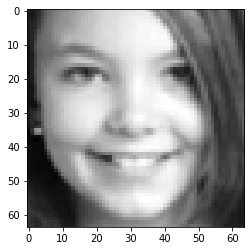

In [10]:
target = np.zeros((size,2),dtype='float32')
features = np.zeros((size,sample.shape[0],sample.shape[1],1),dtype = 'float32')
for i in range(size):
    target[i,0] = age_group(int(ages[i])) / 4
    target[i,1] = int(genders[i])
    features[i] = images[i]
features = features / 255
display(features[550])

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2,shuffle  = True)
print("Samples in Training:",x_train.shape[0])
print("Samples in Testing:",x_test.shape[0])

Samples in Training: 18966
Samples in Testing: 4742


In [12]:
print("Shape of image:",sample.shape)

Shape of image: (64, 64, 1)


In [13]:
import keras 
from keras.layers import *
from keras.models import *
from keras import backend as K

In [14]:
inputs = Input(shape=(64,64,1))
conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3),activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
x = Dropout(0.25)(pool2)
flat = Flatten()(x)

dropout = Dropout(0.5)
age_model = Dense(128, activation='relu')(flat)
age_model = dropout(age_model)
age_model = Dense(64, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(32, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(1, activation='relu')(age_model)

dropout = Dropout(0.5)
gender_model = Dense(128, activation='relu')(flat)
gender_model = dropout(gender_model)
gender_model = Dense(64, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(32, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(16, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(8, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(1, activation='sigmoid')(gender_model)


In [15]:
model = Model(inputs=inputs, outputs=[age_model,gender_model])
model.compile(optimizer = 'adam', loss =['mse','binary_crossentropy'],metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 62, 62, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 60, 60, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 30, 30, 64)   0           ['conv2d_1[0][0]']               
                                                                                              

In [17]:
h = model.fit(x_train,[y_train[:,0],y_train[:,1]],validation_data=(x_test,[y_test[:,0],y_test[:,1]]),epochs = 5, batch_size=128,shuffle = True)

Epoch 1/5
149/149 [==============================] - 398s 3s/step - loss: 0.7549 - dense_3_loss: 0.0736 - dense_9_loss: 0.6813 - dense_3_accuracy: 0.0151 - dense_9_accuracy: 0.5243 - val_loss: 0.6782 - val_dense_3_loss: 0.0382 - val_dense_9_loss: 0.6401 - val_dense_3_accuracy: 0.0245 - val_dense_9_accuracy: 0.7269
Epoch 2/5
149/149 [==============================] - 398s 3s/step - loss: 0.6607 - dense_3_loss: 0.0509 - dense_9_loss: 0.6098 - dense_3_accuracy: 0.0207 - dense_9_accuracy: 0.7220 - val_loss: 0.5399 - val_dense_3_loss: 0.0300 - val_dense_9_loss: 0.5099 - val_dense_3_accuracy: 0.0243 - val_dense_9_accuracy: 0.8157
Epoch 3/5
149/149 [==============================] - 397s 3s/step - loss: 0.5895 - dense_3_loss: 0.0439 - dense_9_loss: 0.5456 - dense_3_accuracy: 0.0225 - dense_9_accuracy: 0.7721 - val_loss: 0.5049 - val_dense_3_loss: 0.0254 - val_dense_9_loss: 0.4795 - val_dense_3_accuracy: 0.0264 - val_dense_9_accuracy: 0.8330
Epoch 4/5
149/149 [==============================] -

In [18]:
model.save('data.h5')

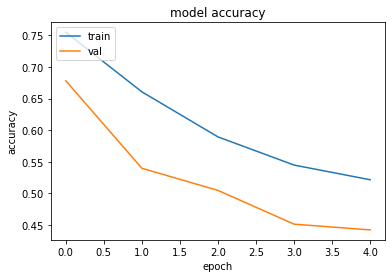

In [19]:
history = h
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [9]:
import tensorflow
import numpy as np
mod=tensorflow.keras.models.load_model('data.h5')
def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()
    
def age_group(age):
    if age >=0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4
def get_age(distr):
    distr = distr*4
    if distr >= 0.65 and distr <= 1.4:return "0-18"
    if distr >= 1.65 and distr <= 2.4:return "19-30"
    if distr >= 2.65 and distr <= 3.4:return "31-80"
    if distr >= 3.65 and distr <= 4.4:return "80 +"
    return "Unknown"
    
def get_gender(prob):
    if prob < 0.5:return "Male"
    else: return "Female"

def get_result(sample):
    sample = sample/255
    val = mod.predict( np.array([ sample ]) )    
    age = get_age(val[0])
    gender = get_gender(val[1])
    print("Values:",val,"\nPredicted Gender:",gender,"Predicted Age:",age)
    
    
#indexes = [500,59,80,2,4546,7,9,256,45]
#for idx in indexes:
 #   sample = images[idx]
  #  display(sample)
  #  print("Actual Gender:",get_gender(genders[idx]),"Age:",ages[idx])
   # res = get_result(sample)

In [2]:
import face_recognition
import cv2
cap=cv2.VideoCapture(0)
#mod=tensorflow.keras.models.load_model('saved')
while(True):
    ret,frame=cap.read()
    roi=frame[100:400,320:620]
    cv2.imshow('roi',roi)
    
    roi=cv2.cvtColor(roi,cv2.COLOR_BGR2GRAY)
    roi=cv2.resize(roi,(64,64),interpolation=cv2.INTER_AREA)
    
    #cv2.imshow('roi scaled and gray',roi)
    
    copy=frame.copy()
    cv2.rectangle(copy,(320,100),(620,400),(255,0,0),5)
    
    roi=roi.reshape(64,64,1)
    
    res=get_result(roi)
    #if(cv2.waitKey(1)=='r'):
       # print(res)
    
    cv2.putText(copy,(res),(300,100),cv2.FONT_HERSHEY_COMPLEX,2,(0,255,0),2)
    cv2.imshow('frame',copy)
    
    if(cv2.waitKey(1)==13):
        break
        
cap.release()
cv2.destroyAllWindows()

ModuleNotFoundError: No module named 'face_recognition'